<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/Predicting_PulsarStar_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6425713790013106
GPU (s):
0.1902426819997345
GPU speedup over CPU: 19x


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

df = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/pulsar_stars.csv')
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


<font color=red size=6>
Above Read from CSV returns DataFrame <br>
Below genfromtxt returns array

In [0]:
#filepath = 'My Drive/MyLearning/MLDLAIPython/Data/TextData/pulsar_stars.csv' #your path here
#df = np.genfromtxt(filepath, delimiter=',', dtype='float64')

In [0]:
df.shape

(17898, 9)

<font color=brown size=5>
PCA starts

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler(feature_range=[0,1])

df_scaled = scaler.fit_transform(df.iloc[1:, 0:8])

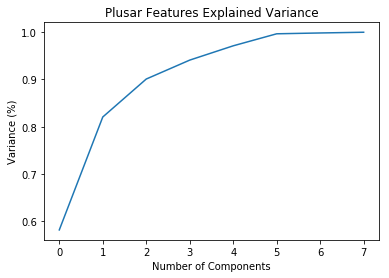

In [0]:
#Fitting the PCA algorithm with our Data

pca = PCA().fit(df_scaled)

#Plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Plusar Features Explained Variance')
plt.show()

<font color=green size=4>
After 5 the Variance has flattened meaning, features in components (unfortunately, we do not know what these features are) after 5 have negligible contribution. <br>
By using 5 components, we have almost 98%-99% of the Variance Explained. The aim of PCA is to have the maximum explanation. So, instead of all components, we will have only the primary components that is 5


In [0]:
pca = PCA(n_components=5)
dataset = pca.fit_transform(df_scaled)

Now we will use Decision Tree with Tunning to predict the results, that is, if the given star is Pulsar or not.

In [0]:

# Prepare data for training models
labels = np.array(df.iloc[1:,8:9])
"""
labels = df.iloc[1:, 8:9]
labels.head(2)
#df.head()
"""

'\nlabels = df.iloc[1:, 8:9]\nlabels.head(2)\n#df.head()\n'

In [0]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=42)

In [0]:
print ('X_train.shape -->', X_train.shape)
print ('X_test.shape -->', X_test.shape)
print ('y_train.shape -->', y_train.shape)
print ('y_test.shape -->', y_test.shape)

X_train.shape --> (13422, 5)
X_test.shape --> (4475, 5)
y_train.shape --> (13422, 1)
y_test.shape --> (4475, 1)


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib.legend_handler import HandlerLine2D

In [0]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred = dt.predict(X_test)

In [0]:
dt.score(X_train, y_train)

1.0

In [0]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

In [0]:
roc_auc

0.8958006940057839

<font color=brown size=6>
max_depth <br>
<font color=brown size=4>
The first parameter to tune is max_depth. This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. We fit a decision tree with depths ranging from 1 to 32 and plot the training and test auc scores.

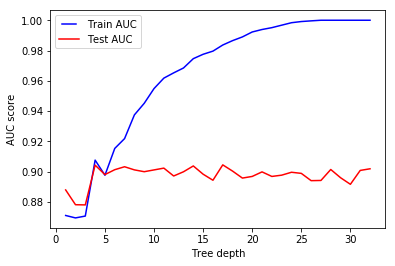

In [0]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

<font color=red size=4>
We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data <br>
<font color=brown size=6> 
min_samples_split <br><font color=brown size=4> 
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

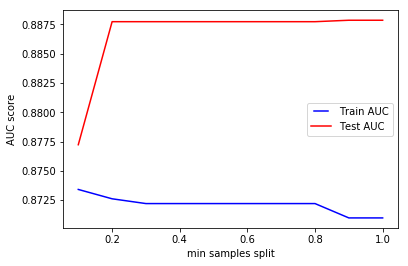

In [0]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

<font color=blue size=4>
After 0.25 Min Sample Splits, learning stopped. At leasat it did not come down resulting in underfitting.<br><br>
<font color=brown size=6>
min_samples_leaf <font color=brown size=4>
min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

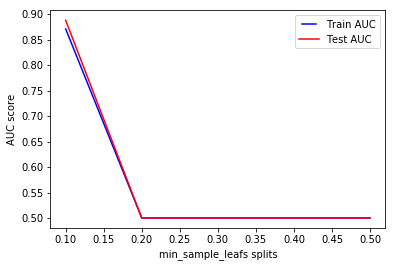

In [0]:
min_sample_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []
for min_samples_leaf in min_sample_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thersholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_sample_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_sample_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_sample_leafs splits')
plt.show()

<font color=red size=5>
Increasing Min Sample Leafs causing underfitting
<br><br>
<font color=brown size=6>
max_features<br>
<font color=brown size=4>
max_features represents the number of features to consider when looking for the best split.

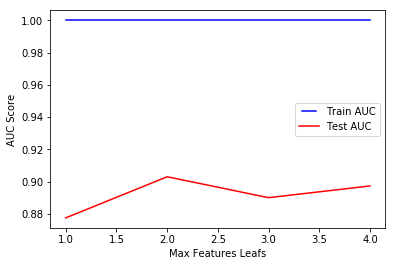

In [0]:
max_features = list(range(1, dataset.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(X_train, y_train)  
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import  HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("Max Features Leafs")
plt.show()


<font color=red size=4>
This is an overfitting case.  It’s unexpected to get overfitting for all values of max_features. However, according to sklearn documentation for decision tree, the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

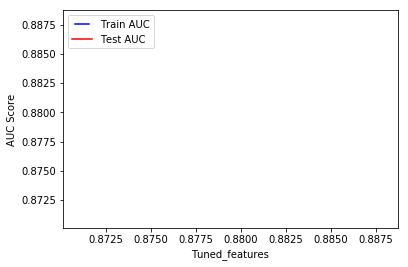

In [0]:
dt = DecisionTreeClassifier(max_features=2, max_depth = 25, min_samples_split= 0.1, min_samples_leaf = 0.1)
"""
grid = [
             {'max_features' : 2,
             'max_depth' : 25,
             'min_samples_split' : 0.1,
             'min_samples_leaf' : 0.2
              }
            ]

dt = DecisionTreeClassifier(grid)
"""
dt.fit(X_train, y_train)  

train_pred = dt.predict(X_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
roc_auc_tr = auc(false_positive_rate, true_positive_rate)

y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc_te = auc(false_positive_rate, true_positive_rate)

from matplotlib.legend_handler import  HandlerLine2D
line1, = plt.plot(roc_auc_tr, roc_auc_tr, 'b', label="Train AUC")
line2, = plt.plot(roc_auc_te, roc_auc_te, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("Tuned_features")
plt.show()

In [0]:
recall_score(y_test, y_pred)
roc_curve(y_test, y_pred)

(array([0.        , 0.06968727, 1.        ]),
 array([0.        , 0.84541063, 1.        ]),
 array([2, 1, 0]))

In [0]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      4061
           1       0.55      0.85      0.67       414

    accuracy                           0.92      4475
   macro avg       0.77      0.89      0.81      4475
weighted avg       0.94      0.92      0.93      4475



In [0]:
report = classification_report(y_train, train_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     12197
           1       0.53      0.82      0.64      1225

    accuracy                           0.92     13422
   macro avg       0.75      0.87      0.80     13422
weighted avg       0.94      0.92      0.92     13422

